# Analysis of Daily Historical Future Variables from LOCA and BCSD

This notebook analyzes daily hydrologic variables from the historical (1950-2005) and RCP (2006-2100) scenarios from the LOCA and BCSD datasets. The daily datasets are used here to assess the statistical extremes ($RO_{20yr}$ and $7RO10$).

Variables include:
- Total Runoff

In [4]:
from loca import print_date
print_date()

Last executed: 2018-04-18 15:49:19.874371 by jhamman on r8i4n0


# Imports and Options

In [5]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

import os
import matplotlib.pyplot as plt

import xarray as xr

from loca.data_catalog import load_daily_cmip_hydro_datasets
from loca.utils import calc_change

models = ['ACCESS1-0', 'CanESM2', 'CNRM-CM5', 'MIROC5', 'MRI-CGCM3']
models = ['CCSM4', 'CNRM-CM5']

hydro_vars = ['ET', 'total_runoff']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
from dask.distributed import Client
client = Client(scheduler_file='/glade/u/home/jhamman/workdir/scheduler_file.json')
client

Client Scheduler: tcp://10.148.7.109:38258 Dashboard: http://10.148.7.109:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


# Load Data

In [7]:
hist_data = load_daily_cmip_hydro_datasets('historical', models=models, autoclose=True, parallel=True)
rcp4_data = load_daily_cmip_hydro_datasets('rcp45', models=models, autoclose=True, parallel=True)
rcp8_data = load_daily_cmip_hydro_datasets('rcp85', models=models, autoclose=True, parallel=True)

load_daily_cmip_hydro_datasets
load_daily_loca_hydrology
load_daily_bcsd_hydrology
load_bcsd_dataset
load_daily_cmip_hydro_datasets
load_daily_loca_hydrology
load_daily_bcsd_hydrology
load_bcsd_dataset
load_daily_cmip_hydro_datasets
load_daily_loca_hydrology
load_daily_bcsd_hydrology
load_bcsd_dataset


In [8]:
import ocgis
from ocgis.constants import DriverKey
from geopandas import GeoDataFrame
import numpy as np
from dask import delayed, compute

In [9]:
gdfs = [GeoDataFrame.from_file('/glade/p/ral/RHAP/jhamman/inputdata/shapefiles/wbd/WBD_{0:02d}_Shape/Shape/WBDHU4.shp'.format(d))
        for d in range(1, 19)]

In [10]:
import pandas as pd

hucs = pd.concat(gdfs)

In [11]:
len(hucs)

202

In [13]:
x = ocgis.Variable(name='lon', dimensions='lon', value=hist_data['loca']['lon'].values)
y = ocgis.Variable(name='lat', dimensions='lat', value=hist_data['loca']['lat'].values)
grid = ocgis.Grid(x, y, crs=ocgis.crs.Spherical())

In [47]:
@delayed
def get_mask(grid, subset_geom):
    try:
        sub, slc = grid.get_intersection(subset_geom, return_slice=True)
        dims = [d.name for d in grid.dimensions]
        coords = {}
        for coord in grid.coordinate_variables:
            coords[coord.name] = coord.get_value()
        for dim, slc in zip(dims, slc):
            coords[dim] = coords[dim][slc]
        da = xr.DataArray(sub.weights, dims=dims, coords=coords).fillna(0)
    except:
        return None
    return da

In [48]:
m = get_mask(grid, subset_geom)
m

Delayed('get_mask-d97baaa2-30b4-4538-bf9d-8e4c0e04bfe5')

In [42]:
client.scatter(grid)

<Future: status: finished, type: Grid, key: Grid-80eb2f7eb2c3d28cc8b19137b34af0f1>

In [43]:
# Path to the input ESRI Shapefile.
PATH_SHP = '/glade/p/ral/RHAP/jhamman/inputdata/shapefiles/camels/HCDN_nhru_final_671.shp'
gdf = GeoDataFrame.from_file(PATH_SHP).set_index('hru_id')

<class 'shapely.geometry.multipolygon.MultiPolygon'>


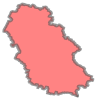

In [44]:
subset_geom = gdf['geometry'].iloc[2]
print(type(subset_geom))
subset_geom

In [49]:
# we'll compute the masks in parallel using dask
delayed_list = [get_mask(grid, geom) for geom in gdf['geometry']]

In [ ]:
computed = compute(delayed_list)

In [88]:
shape = (len(gdf), ) + grid.shape
print(shape)
weights = np.zeros(shape)

# collect all the weights into a single array
for i, (w, slc) in enumerate(computed[0]):
    #  w, slc = get_mask_and_slice(grid, geom.geometry)
    if w is not None:
        weights[i, slc['lat'], slc['lon']] = w  # This would be better as a sparse array but for now this does the trick 
        
# make an xarray.DataArray
weights_da = xr.DataArray(weights, dims=('hru_id', 'lat', 'lon'), name='weights')
weights_da.coords['hru_id'] = gdf.index

weights_da = weights_da.chunk(dict(hru_id=1))


weights_da

(671, 222, 462)


<xarray.DataArray 'weights' (hru_id: 671, lat: 222, lon: 462)>
dask.array<shape=(671, 222, 462), dtype=float64, chunksize=(1, 222, 462)>
Coordinates:
  * hru_id   (hru_id) int64 1013500 1022500 1030500 1031500 1047000 1052500 ...
Dimensions without coordinates: lat, lon

In [91]:
ds = hist_data['loca']
ds

<xarray.Dataset>
Dimensions:         (bnds: 2, gcm: 2, lat: 222, lon: 462, time: 20454)
Coordinates:
  * lon             (lon) float32 -124.6875 -124.5625 -124.4375 -124.3125 ...
  * lat             (lat) float32 25.1875 25.3125 25.4375 25.5625 25.6875 ...
  * time            (time) datetime64[ns] 1950-01-01 1950-01-02 1950-01-03 ...
  * gcm             (gcm) <U8 'CCSM4' 'CNRM-CM5'
Dimensions without coordinates: bnds
Data variables:
    longitude_bnds  (gcm, time, lon, bnds) float32 dask.array<shape=(2, 20454, 462, 2), chunksize=(1, 365, 462, 2)>
    latitude_bnds   (gcm, time, lat, bnds) float32 dask.array<shape=(2, 20454, 222, 2), chunksize=(1, 365, 222, 2)>
    ET              (gcm, time, lat, lon) float32 dask.array<shape=(2, 20454, 222, 462), chunksize=(1, 365, 222, 462)>
    SWE             (gcm, time, lat, lon) float32 dask.array<shape=(2, 20454, 222, 462), chunksize=(1, 365, 222, 462)>
    baseflow        (gcm, time, lat, lon) float32 dask.array<shape=(2, 20454, 222, 462), chu

In [92]:
# brute force remapping here
da = (ds['runoff'].chunk(dict(time=100)) * weights_da).sum(('lat', 'lon')) /  weights_da.sum(('lat', 'lon'))

/glade/u/home/jhamman/anaconda/envs/loca/lib/python3.6/site-packages/dask/array/core.py:2187: UserWarning: Increasing number of chunks by factor of 410
  (nparts / max_parts))


In [94]:
da.compute()

KilledWorker: ("('mul-nansum-sum-aggregate-8b38cbdd83cda4daed9495c47d199cfe', 1, 11, 538)", 'tcp://10.148.7.160:49843')

In [5]:
hist_epoch = slice('1969-10-01', '1999-09-30')
futr_epoch = slice('2069-10-01', '2099-09-30')

In [6]:
import numpy as np
from scipy.stats import pearson3

# def calc_extreme_gufunc(vals, q=0.5):
#     '''at = 1 - 1.0/(nyear*365.25)'''
#     params = pearson3.fit(vals)
#     return pearson3.ppf(at, *params)


# def calc_extreme(vals, q):
#     return xr.apply_ufunc(calc_extreme_gufunc, vals,
#                           dask='parallelized', vectorize=True,
#                           kwargs=dict(q=q),
#                           input_core_dims=[['time']],
#                           output_dtypes=[vals.dtype],
#                           keep_attrs=True)


def calc_extreme_gufunc(vals, q=0.5, axis=-1):
    return np.nanpercentile(vals, q=q * 100, axis=axis)

def calc_extreme(vals, q):
    return xr.apply_ufunc(calc_extreme_gufunc, vals,
                          dask='parallelized',
                          kwargs=dict(axis=-1, q=q),
                          input_core_dims=[['time']],
                          output_dtypes=[vals.dtype],
                          keep_attrs=True)

    

In [7]:
import numpy as np

In [8]:
def calc_ro20yr(da, q=1 - 1./20.):
    chunks = {'lat': 50, 'lon': 50, 'time': 366}
    ymax = da.resample(time='A-OCT').max('time')
    ymax = ymax.compute().chunk({'time': len(ymax['time']), 'gcm': 1, 'lat': 50, 'lon': 50})
    return calc_extreme(ymax, q=q)


def calc_7ro10(da, q=1 - 1./10.):
    weekly_ro = da.resample(time='7D').mean('time')
    weekly_ro = weekly_ro.persist().chunk({'time': len(weekly_ro['time']), 'gcm': 1, 'lat': 50, 'lon': 50})
    ymin = weekly_ro.resample(time='A-OCT').min('time')
    ymin = ymin.compute().chunk({'time': len(ymin['time']), 'gcm': 1, 'lat': 50, 'lon': 50})
    return calc_extreme(ymin, q=q)

In [9]:
mask = hist_data['bcsd']['total_runoff'].isel(gcm=0, time=0).squeeze().notnull()


In [ ]:
mask.plot()

In [ ]:
var = 'total_runoff'

plot_data = {}


for stat, func in [('$RO_{20yr}$', calc_ro20yr), ('$7RO10$', calc_7ro10)]:
    print(stat, flush=True)
    plot_data[stat] = {}
#     plot_data[stat]['Historical'] = {}
#     for k, ds in hist_data.items():
#         print(k, flush=True)
# #         with dask.set_options(get=dask.get):
#         plot_data[stat]['Historical'][k] = func(ds[var].sel(time=hist_epoch)).compute()
#         break
           
    plot_data[stat]['Historical'] = dict((k, func(ds[var].sel(time=hist_epoch)).compute()) for (k, ds) in hist_data.items())
    plot_data[stat]['RCP 4.5'] = dict((k, func(ds[var].sel(time=futr_epoch)).compute()) for (k, ds) in rcp4_data.items())
    plot_data[stat]['RCP 8.5'] = dict((k, func(ds[var].sel(time=futr_epoch)).compute()) for (k, ds) in rcp8_data.items())


$RO_{20yr}$
$7RO10$


# Plots

For the monthly hydrologic variables, we will make 2 types of plots:

1. Maps of all datasets plotted as actual values (epoch, seasonal, and monthly means)
2. Maps of all datasets with LOCA and BCSD datasets plotted as biases relative to observation based VIC simulations (epoch, seasonal, and monthly means)

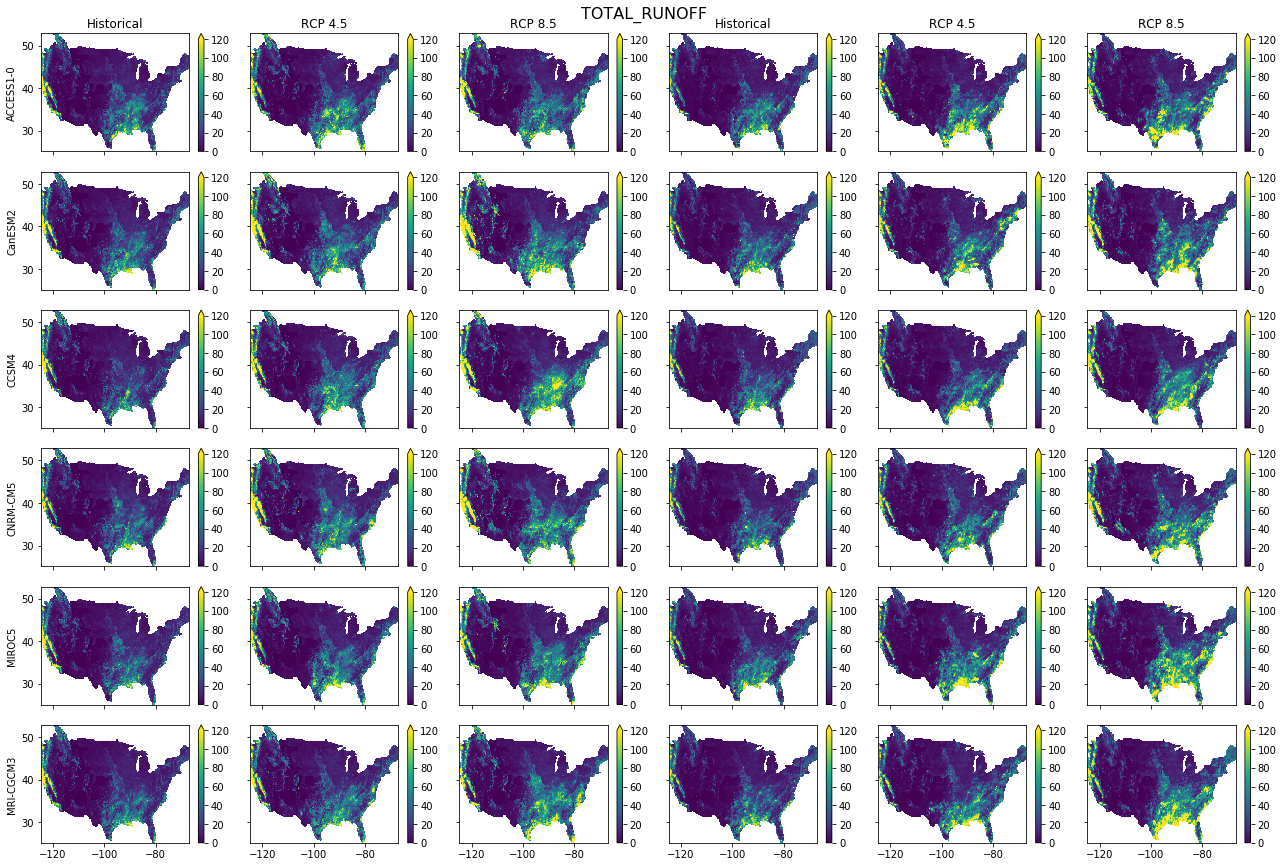

In [46]:
kwargs = {'$RO_{20yr}$': {'vmin': 0, 'vmax': 120},
          '$7RO10$': {'vmin': 0, 'vmax': 0.6}}

var = 'total_runoff'
subcols = ['Historical', 'RCP 4.5', 'RCP 8.5']

# TODO: Fix mask issue with LOCA

for stat, data in plot_data.items():

    fig, axes = plt.subplots(ncols=2*len(subcols), nrows=len(models), sharex=True, sharey=True, figsize=(18, 2*len(models)))
       
    for row, model in enumerate(models):
        for i, dset in enumerate(['bcsd', 'loca']):
            for col, title in enumerate(subcols, i*len(subcols)):
                ax = axes[row, col]
                
                if col == 0:
                    ax.set_ylabel(model)
                if row == 0:
                    ax.set_title(title)
                    
                data[title][dset].sel(gcm=model).where(mask).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[stat])
                
    fig.suptitle(var.upper(), fontsize=16, y=1.0)
    fig.tight_layout()    


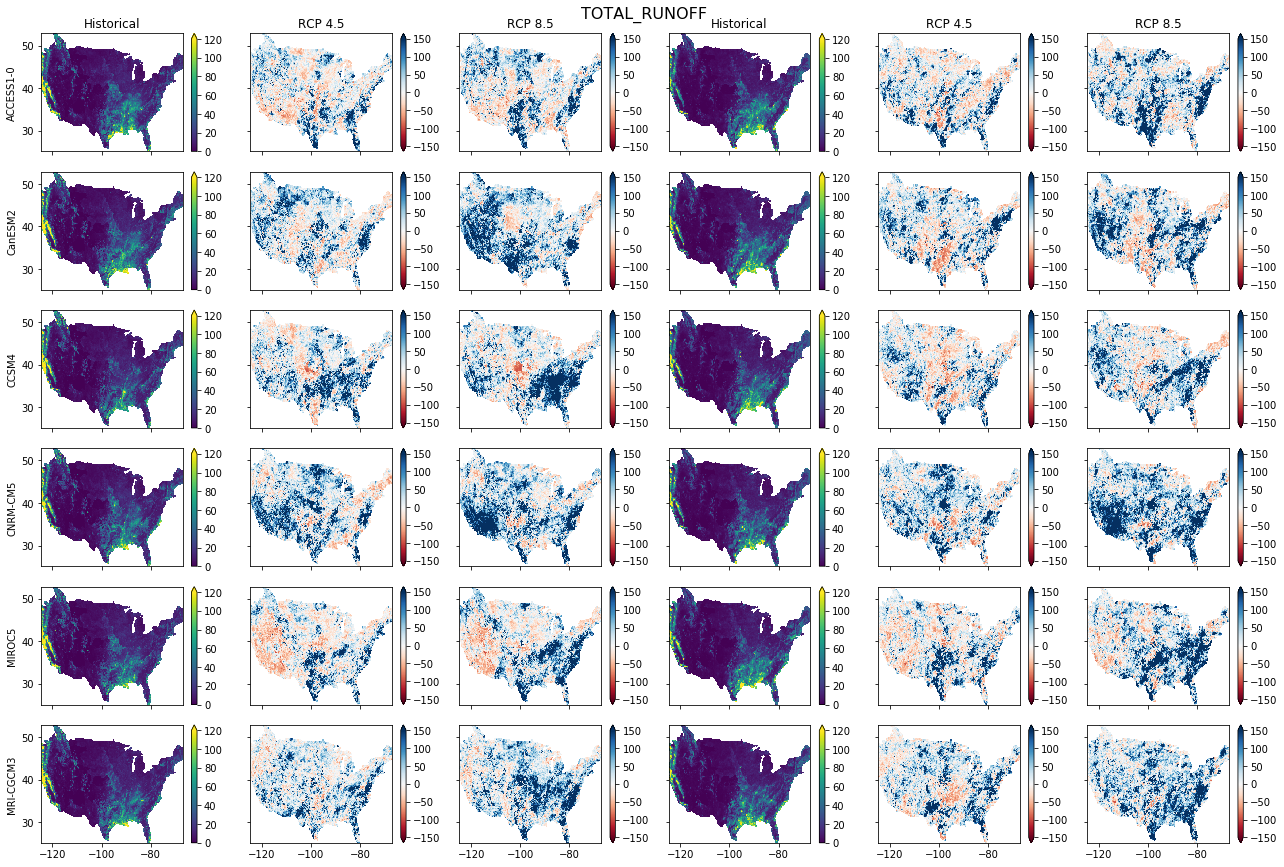

In [48]:
diff_kws = {'$RO_{20yr}$': {'vmin': -150, 'vmax': 150, 'cmap': 'RdBu', 'extend': 'both'},
            '$7RO10$': {'vmin': -0.1, 'vmax': 0.1, 'cmap': 'RdBu', 'extend': 'both'}}

for stat, data in plot_data.items():

    fig, axes = plt.subplots(ncols=2*len(subcols), nrows=len(models), sharex=True, sharey=True, figsize=(18, 2*len(models)))
       
    for row, model in enumerate(models):
        for i, dset in enumerate(['bcsd', 'loca']):
            for col, title in enumerate(subcols, i*len(subcols)):
                ax = axes[row, col]
                
                if col == 0:
                    ax.set_ylabel(model)
                if row == 0:
                    ax.set_title(title)
                    
                if 'RCP' in title:
                    change = calc_change(data['Historical'][dset].sel(gcm=model), data[title][dset].sel(gcm=model), pct=True).persist()
                    change.where(mask).plot.pcolormesh(ax=ax, add_labels=False, **diff_kws[stat])
                else:
                    data[title][dset].sel(gcm=model).where(mask).plot.pcolormesh(ax=ax, add_labels=False, **kwargs[stat])

                    
    fig.suptitle(var.upper(), fontsize=16, y=1.0)
    fig.tight_layout()    


In [49]:
inds = np.nonzero(mask.values)
inds


(array([  0,   0,   0, ..., 221, 221, 221]),
 array([349, 350, 351, ...,  45,  46,  47]))

Text(0.5,0,'LOCA')

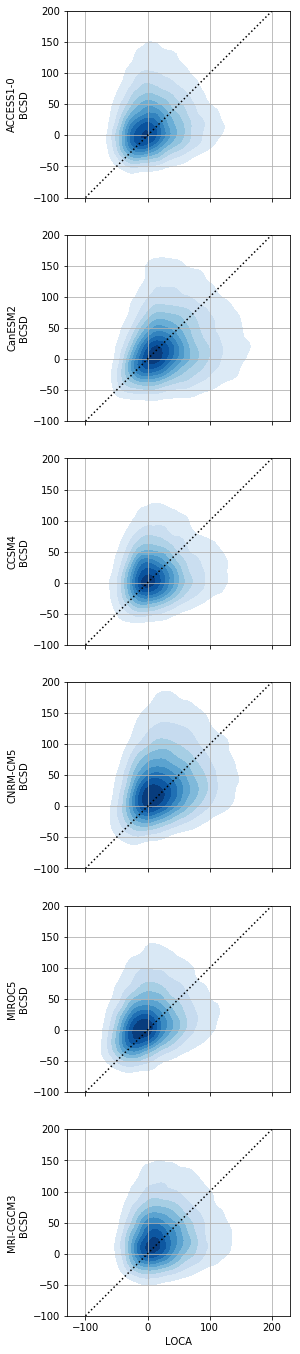

In [52]:
import seaborn as sns

fig, axes = plt.subplots(nrows=len(models), sharex=True, sharey=True, subplot_kw=dict(aspect='equal'), figsize=(4, 4*len(models)))
for i, model in enumerate(models):
    ax = axes[i]
    
    bcsd_change = calc_change(data['Historical']['bcsd'].sel(gcm=model), data['RCP 8.5']['bcsd'].sel(gcm=model), pct=True).load()
    loca_change = calc_change(data['Historical']['loca'].sel(gcm=model), data['RCP 8.5']['loca'].sel(gcm=model), pct=True).load()

    ax.plot([-100, 200], [-100, 200], 'k:')
    sns.kdeplot(bcsd_change.fillna(0).values[inds],
                loca_change.fillna(0).values[inds],
                cmap="Blues", shade=True,
                shade_lowest=False,
                clip=(-100, 500), ax=ax)
    
    ax.set_xlim([-100, 200])
    ax.set_ylim([-100, 200])
    ax.set_ylabel(model + '\nBCSD')
    ax.grid()
ax.set_xlabel('LOCA')


In [ ]:
plt.close('all')